In [2]:
''' mainly used to make sure that C nmr works better than HSQC'''
# pip install umap-learn
import umap
import torch
torch.set_printoptions(precision=10)

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from models.optional_input_ranked_transformer import OptionalInputRankedTransformer
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
from datasets.hsqc_folder_dataset import FolderDataModule
import yaml
from pytorch_lightning.loggers import TensorBoardLogger
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets import dataset_utils
from datasets.dataset_utils import specific_radius_mfp_loader

            


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np 
import pickle 
import time
import tqdm, os
import random


In [4]:
FP_building_type = "Normal"
only_2d = False
max_r = 2
specific_radius_mfp_loader.setup(only_2d=only_2d,FP_building_type=FP_building_type)
specific_radius_mfp_loader.set_max_radius(max_r, only_2d=only_2d)






In [5]:
from collections import defaultdict
# default dict of default dict
file_indices = defaultdict(lambda: defaultdict(list))

In [9]:
for split in ['train','val','test']:
    up_bound = 10000 if split == 'train' else 1000
    for datasrc in ['2d', "1d"]:
        dataset_path = Path(f'/workspace/SMILES_dataset/{split}/HSQC') if datasrc == "2d" else \
                        Path(f'/workspace/OneD_Only_Dataset/{split}/oneD_NMR')
        file_indices[split][datasrc] += list(map(lambda x: int(x.split('.')[0]),os.listdir(dataset_path)))
        random.shuffle(file_indices[split][datasrc])
        file_indices[split][datasrc] = file_indices[split][datasrc][:up_bound]

In [10]:
# file_indices

In [11]:
all_FP= {
    "train": [],
    "val": [],
    "test": []
}

for split in ['train','val','test']:
    for datasrc in ['2d', "1d"]:
        for i in file_indices[split][datasrc]:
            all_FP[split].append(specific_radius_mfp_loader.build_mfp(i,datasrc,split))

In [12]:
new_molecules = []
for compound_SMILES in [
    "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O",
    "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
]:
    
    new_molecules.append(specific_radius_mfp_loader.build_mfp_for_new_SMILES(compound_SMILES))

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

def build_umap(all_trainset_tensors, all_valset_tensors, all_testset_tensors, new_molecules):
    train_checkpoint = len(all_trainset_tensors)
    val_checkpoint = len(all_valset_tensors)+train_checkpoint
    test_checkpoint = len(all_testset_tensors) + val_checkpoint


    umap_reducer = umap.UMAP(n_components=2)
    to_stack = [
                all_trainset_tensors,
                all_valset_tensors,
                all_testset_tensors,
                ]
    if new_molecules:
        to_stack.append(new_molecules)
    all_features = np.vstack(to_stack)
    X_umap = umap_reducer.fit_transform(all_features)
        
        
    plt.figure(figsize=(8, 6))
    plt.scatter(x=X_umap[:train_checkpoint, 0], y=X_umap[:train_checkpoint, 1], c='r', s=10)
    plt.scatter(x=X_umap[train_checkpoint:val_checkpoint, 0], y=X_umap[train_checkpoint:val_checkpoint, 1], c='g', s=10)
    plt.scatter(x=X_umap[val_checkpoint:test_checkpoint, 0], y=X_umap[val_checkpoint:test_checkpoint, 1], c='y', s=10)
    plt.scatter(x=X_umap[test_checkpoint:, 0], y=X_umap[test_checkpoint:, 1], c='c', s=20)

    plt.legend(['train', 'val', 'test', 'new_molecules'])


    plt.title('UMAP of all representations')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.show()
        




<Figure size 800x600 with 0 Axes>

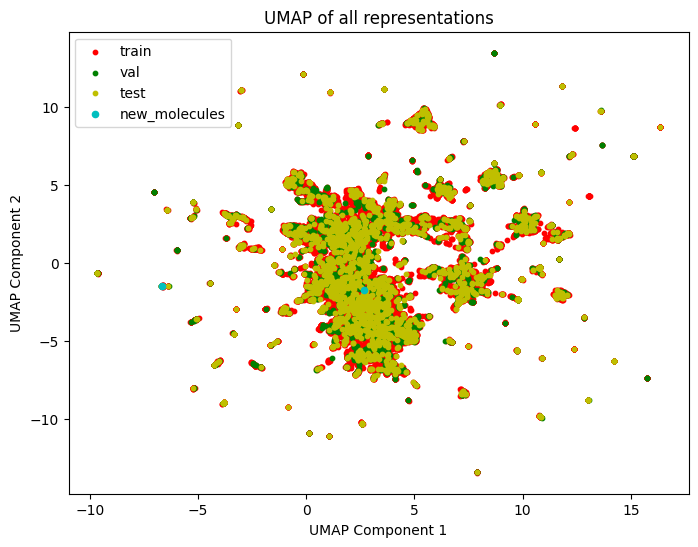

In [14]:

build_umap(all_FP["train"], all_FP["val"], all_FP["test"], new_molecules)

In [15]:
len(all_FP["test"])

2000

In [16]:
HYUN_FP= {
    "train": [],
    "val": [],
    "test": []
}

for split in ['train','val','test']:
    for datasrc in ['2d', "1d"]:
        dataset_path = Path(f'/workspace/SMILES_dataset/{split}') if datasrc == "2d" else \
                        Path(f'/workspace/OneD_Only_Dataset/{split}')
        for i in file_indices[split][datasrc]:
            HYUN_FP[split].append(torch.load(dataset_path/"HYUN_FP"/f"{i}.pt"))

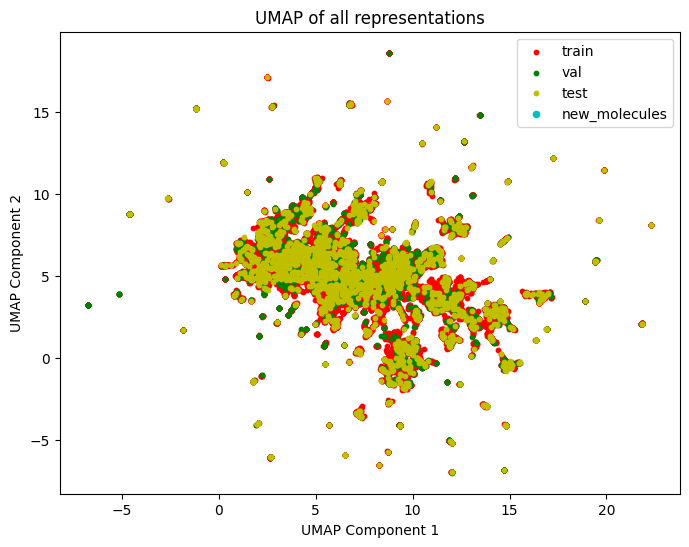

In [21]:

build_umap(HYUN_FP["train"], HYUN_FP["val"], HYUN_FP["test"], new_molecules = [])